In [7]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, colors as colors
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *

import sys
sys.path.append('../../JazzHands/')
from jazzhands import *

import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
from exoplanet import estimate_inverse_gamma_parameters
import exoplanet as xo
import corner

In [8]:
massive_observed = pd.read_csv('../data/massive_observed.csv')
lbvs = massive_observed[massive_observed['SpT']=='LBV'].reset_index(drop=True)
#let's add in T_effs and Ls
logT_q = [4.26,4.26,4.23,4.58,4.3,4.4,4.46]
logL = [5.70,6.1,6.3,5.68,5.82,6.54,5.80]
source = ['1','1','1','4','2,3','2','4']
names = ['P Cyg','$\zeta^1$ Sco$^*$','HD 80077$^*$','HD 148937$^*$','S Dor','$\eta$ Car','HD 269582']
source_dict = {'1':'clark05b','2':'humphreys94','3':'lamers95','4':'vangenderen01'}
lbvs['logT_q'] = logT_q
lbvs['logL'] = logL
lbvs['Spec_source'] = source
lbvs['TeX_name'] = names
lbvs.sort_values('logT_q',inplace=True)
lbvs = lbvs[lbvs['CommonName'] != '* eta Car'].reset_index(drop=True)
lbvs

,TIC ID,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,SimbadOType,SimbadSpT,logT_q,logL,Spec_source,TeX_name
0,391624171,138.978279,-49.973493,0.039651,-5.295830,4.813780,5.7508,NaN,LBV,HD 80077,B,BlueSG*,B2Ia+e,4.23,6.30,1,HD 80077$^*$
1,12149245,304.446674,38.032930,0.054074,-3.498230,-6.819400,4.2616,NaN,LBV,* P Cyg,B2pe,BlueSG*,B1-2Ia-0ep,4.26,5.70,1,P Cyg
2,246962305,253.498863,-42.362032,0.035873,0.008812,-2.939490,4.3819,NaN,LBV,* zet01 Sco,B1p,BlueSG*,B1Ia-0ek,4.26,6.10,1,$\zeta^1$ Sco$^*$
3,179305185,79.559822,-69.250319,0.051135,1.734760,0.279512,7.4155,NaN,LBV,V* S Dor,A5Iaeq,SG*,A5Iaeq,4.30,5.82,"2,3",S Dor
4,279957111,81.969425,-68.985691,0.078509,1.739400,0.485263,10.5263,NaN,LBV,HD 269582,NaN,WR*,WN10h,4.46,5.80,4,HD 269582
5,21931623,248.468278,-48.111244,0.040351,0.880148,-3.381430,6.4483,NaN,LBV,HD 148937,B0,SB*,O6f?p,4.58,5.68,4,HD 148937$^*$


In [9]:
tic = lbvs['TIC ID'].loc[lbvs['CommonName'] == 'V* S Dor'].iloc[0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

In [10]:
ls = LombScargle(time, flux, dy=err, normalization='psd')
freq, power = ls.autopower(nyquist_factor=1)
power /= len(time)

[Text(0, 0.5, 'Power'), Text(0.5, 0, 'Frequency')]

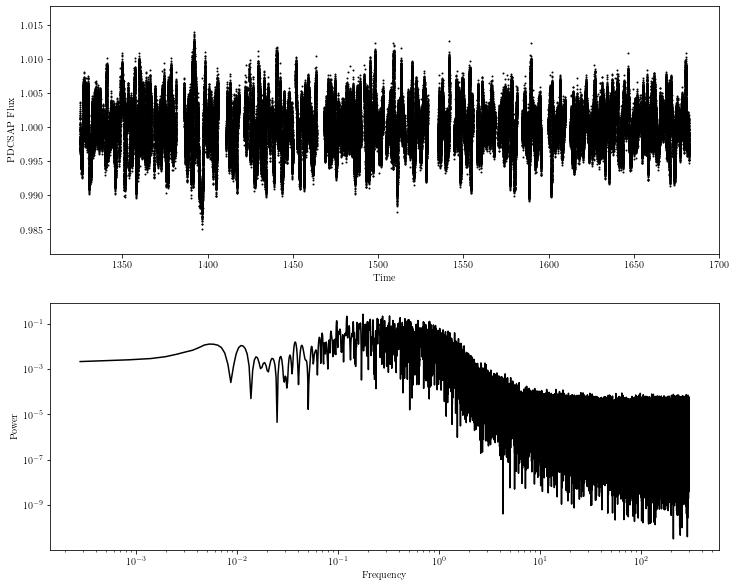

In [11]:
fig, ax = plt.subplots(2, figsize=(12,10))

ax[0].scatter(time, flux, s=1, c='k')
ax[0].set(xlabel='Time', ylabel='PDCSAP Flux')

ax[1].loglog(freq, power, c='k')
ax[1].set(xlabel='Frequency', ylabel='Power')

In [6]:
popt, pcov, resid = fit_red_noise(freq,power)
alpha_0, tau, gamma, alpha_w = popt
s0 = alpha_0
w0 = 2*np.pi/tau
print(s0,w0,np.log(w0))

0.1976719988528826 25.895432808874908 3.2540666137301884


In [9]:
#Define the PyMC3 model

with pm.Model() as model:
    mean = pm.Normal("mean", mu=1.0, sigma=np.std(flux))

    S1 = pm.HalfFlat(r"$S_0$")
    logw1 = pm.Deterministic(r"$\log\omega_0$", pm.HalfFlat(r'$\log\omega_0 + 2$') - 2)
    Q1 = pm.HalfFlat(r"$Q_0$")

    kernel = terms.SHOTerm(S_tot = S1, log_w0=logw1, Q=Q1)

    gp = GP(kernel, time[::15], err[::15] ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=flux[::15])

In [10]:
with model:
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [$Q_0$, $\log\omega_0 + 2$, $S_0$, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 73119.49667710347 -> 77884.1103406822


In [11]:
with model:
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(
        tune=1000,
        draws=3000,
        cores=6,
        chains=3,
        init=map_soln,
        step=step
    )

Multiprocess sampling (3 chains in 6 jobs)
NUTS: [$Q_0$, $\log\omega_0 + 2$, $S_0$, mean]
Sampling 3 chains: 100%|██████████| 12000/12000 [02:26<00:00, 81.67draws/s] 


In [12]:
pm.summary(trace)

/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,1.000091,1.220554e-04,1.283037e-06,0.999857,1.000341,7986.957232,1.000144
$S_0$,0.000011,5.921045e-07,6.996667e-09,0.000010,0.000013,6165.257985,1.000177
$\log\omega_0 + 2$,3.602926,1.926331e-02,2.187693e-04,3.565127,3.640639,6140.100390,1.000056
$\log\omega_0$,1.602926,1.926331e-02,2.187693e-04,1.565127,1.640639,6140.100390,1.000056
$Q_0$,1.006989,5.781200e-02,5.470217e-04,0.892945,1.117416,8581.310868,0.999836


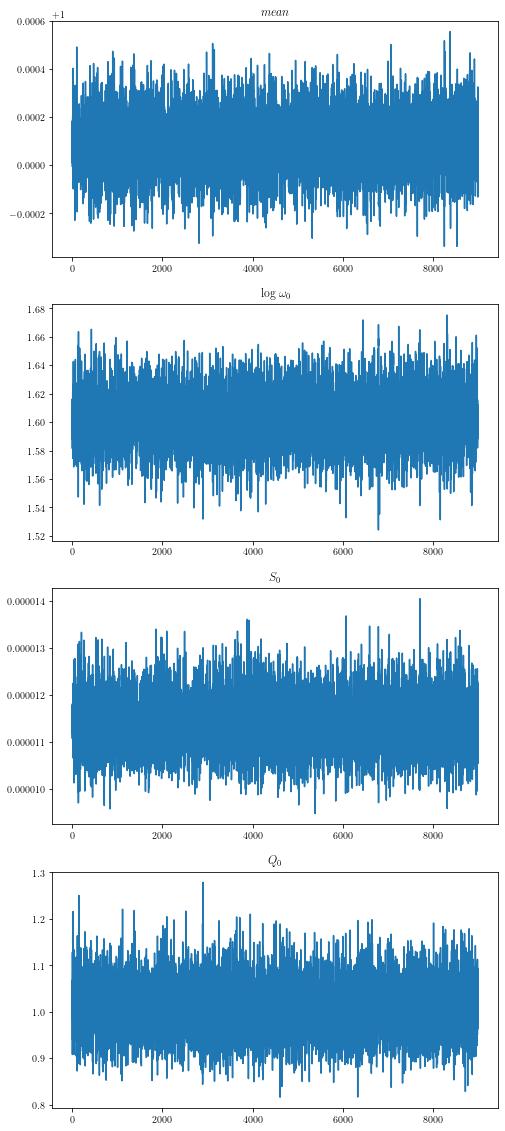

In [13]:
samples = pm.trace_to_dataframe(
    trace, varnames=["mean","$\log\omega_0$","$S_0$","$Q_0$"]
)
fig, ax = plt.subplots(len(samples.columns),figsize=(8,20))
for a, col in zip(ax,samples.columns):
    a.plot(samples[col],label=col)
    a.set_title(r'${}$'.format(col))

In [14]:
samples.median()

mean              1.000091
$\log\omega_0$    1.602927
$S_0$             0.000011
$Q_0$             1.005428
dtype: float64

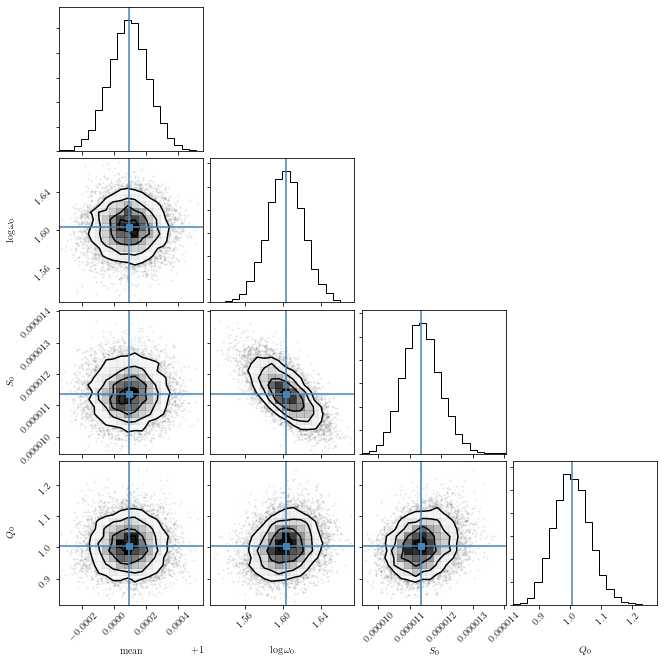

In [15]:
import corner

_ = corner.corner(samples, truths = samples.median())

In [16]:
from tqdm.notebook import tqdm

# Generate 32 realizations of the prediction sampling randomly from the chain
N_pred = 32
pred_t = np.linspace(1350,1450,1000)
pred_mu = np.empty((N_pred, len(pred_t)))
pred_var = np.empty((N_pred, len(pred_t)))
pred_psd = np.empty((N_pred, len(freq)))

with model:
    pred = gp.predict(pred_t, return_var=True, predict_mean=True)
    psd = kernel.psd(2*np.pi*freq)
    for i, sample in tqdm(enumerate(xo.get_samples_from_trace(trace, size=N_pred)), total=N_pred):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)
        pred_psd[i] = xo.eval_in_model(psd, sample)

[Text(0, 0.5, 'PDCSAP Flux'), (1350, 1450), Text(0.5, 0, 'Time')]

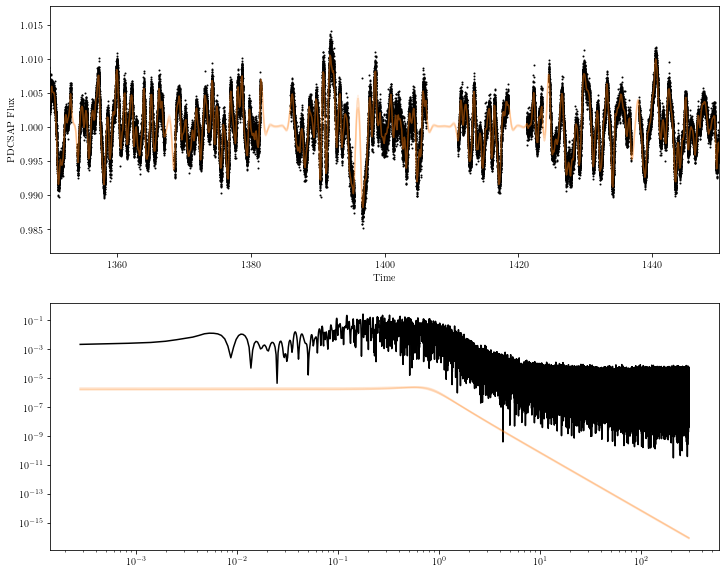

In [17]:
fig, ax = plt.subplots(2, figsize=(12,10))

ax[0].scatter(time, flux, s=1, c="k", label="data")
ax[1].loglog(freq, power, c='k', label='data')

# Plot the predictions
for i in range(len(pred_mu)//5):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    ps = pred_psd[i]
    label = None if i else "prediction"
    #art = ax[0].fill_between(pred_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    #art.set_edgecolor("none")
    ax[0].plot(pred_t, mu, color="C1", label=label, alpha=0.1)
    
    ax[1].loglog(freq, ps, color='C1', alpha=0.1)

ax[0].set(xlim=(1350,1450),xlabel='Time',ylabel='PDCSAP Flux')

# Let's try that SHO plus another one

In [18]:
model_result = pm.summary(trace)
model_result

/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,1.000091,1.220554e-04,1.283037e-06,0.999857,1.000341,7986.957232,1.000144
$S_0$,0.000011,5.921045e-07,6.996667e-09,0.000010,0.000013,6165.257985,1.000177
$\log\omega_0 + 2$,3.602926,1.926331e-02,2.187693e-04,3.565127,3.640639,6140.100390,1.000056
$\log\omega_0$,1.602926,1.926331e-02,2.187693e-04,1.565127,1.640639,6140.100390,1.000056
$Q_0$,1.006989,5.781200e-02,5.470217e-04,0.892945,1.117416,8581.310868,0.999836


In [19]:
model_result.index

Index(['mean', '$S_0$', '$\log\omega_0 + 2$', '$\log\omega_0$', '$Q_0$'], dtype='object')

In [20]:
#Define the PyMC3 model with posteriors as priors...

with pm.Model() as model2:
    #posteriors into priors...
    mean_mean = model_result['mean']['mean']
    mean_sd = model_result['sd']['mean']
    mean = pm.Normal("mean", mu=mean_mean, sigma=mean_sd)
    
    S1_mean = model_result['mean']['$S_0$']
    S1_sd = model_result['sd']['$S_0$']
    S1 = pm.Normal("$S_0$", mu=S1_mean, sigma=S1_sd)

    logw1_mean = model_result['mean']['$\log\omega_0$']
    logw1_sd = model_result['sd']['$\log\omega_0$']
    logw1 = pm.Normal("$\log\omega_0$", mu=logw1_mean, sigma=logw1_sd)
    
    Q1_mean = model_result['mean']['$Q_0$']
    Q1_sd = model_result['sd']['$Q_0$']
    Q1 = pm.Normal("$Q_0$", mu=Q1_mean, sigma=Q1_sd)

    kernel = terms.SHOTerm(S_tot = S1, log_w0=logw1, Q=Q1)
    
    #add another SHO with uninformitive priors...
    S2 = pm.HalfFlat(r"$S_1$")
    logw2 = pm.Deterministic(r"$\log\omega_1$", pm.HalfFlat(r'$\log\omega_1 + 2$') - 2)
    Q2 = pm.HalfFlat(r"$Q_1$")
    
    kernel += terms.SHOTerm(S_tot = S2, log_w0=logw2, Q=Q2)

    gp = GP(kernel, time[::15], err[::15] ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=flux[::15])

In [21]:
with model2:
    map_soln = xo.optimize(start=model2.test_point)

optimizing logp for variables: [$Q_1$, $\log\omega_1 + 2$, $S_1$, $Q_0$, $\log\omega_0$, $S_0$, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 73086.38605419874 -> 73086.38605419874


In [22]:
with model2:
    step = pm.NUTS(target_accept=0.9)
    trace2 = pm.sample(
        tune=1000,
        draws=3000,
        cores=6,
        chains=3,
        step=step
    )

Multiprocess sampling (3 chains in 6 jobs)
NUTS: [$Q_1$, $\log\omega_1 + 2$, $S_1$, $Q_0$, $\log\omega_0$, $S_0$, mean]
Sampling 3 chains:  58%|█████▊    | 6911/12000 [38:06<28:03,  3.02draws/s]  
There were 2807 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


## That runs really slow and has an incredibly hard time converging

# How about a damped random walk?

In [24]:
#Define the PyMC3 model...

with pm.Model() as model_drw:
    #posteriors into priors...
    mean = pm.Normal("mean", mu=1.0, sigma=np.std(flux))
    
    sigma = pm.Normal("$\sigma$", mu=np.std(flux), sigma=np.max(flux)-np.mean(flux))
    
    a = pm.Deterministic("$\sigma^2$", sigma ** 2.0)
    
    logtau = pm.Uniform(r"$\log\tau$", np.log(1/10), np.log(100))
    
    c = pm.Deterministic(r"$\tau^{-1}$", 1.0 / np.exp(logtau))

    kernel = terms.RealTerm(a=a, c=c)

    gp = GP(kernel, time[::15], err[::15] ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=flux[::15])

In [25]:
with model_drw:
    map_soln = xo.optimize(start=model_drw.test_point)

optimizing logp for variables: [$\log\tau$, $\sigma$, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 75523.23791234502 -> 77094.8655145974


In [26]:
with model_drw:
    step = pm.NUTS(target_accept=0.9)
    trace_drw = pm.sample(
        tune=1000,
        draws=3000,
        cores=6,
        chains=3,
        init=map_soln,
        step=step
    )

Multiprocess sampling (3 chains in 6 jobs)
NUTS: [$\log\tau$, $\sigma$, mean]
Sampling 3 chains: 100%|██████████| 12000/12000 [02:00<00:00, 99.62draws/s] 


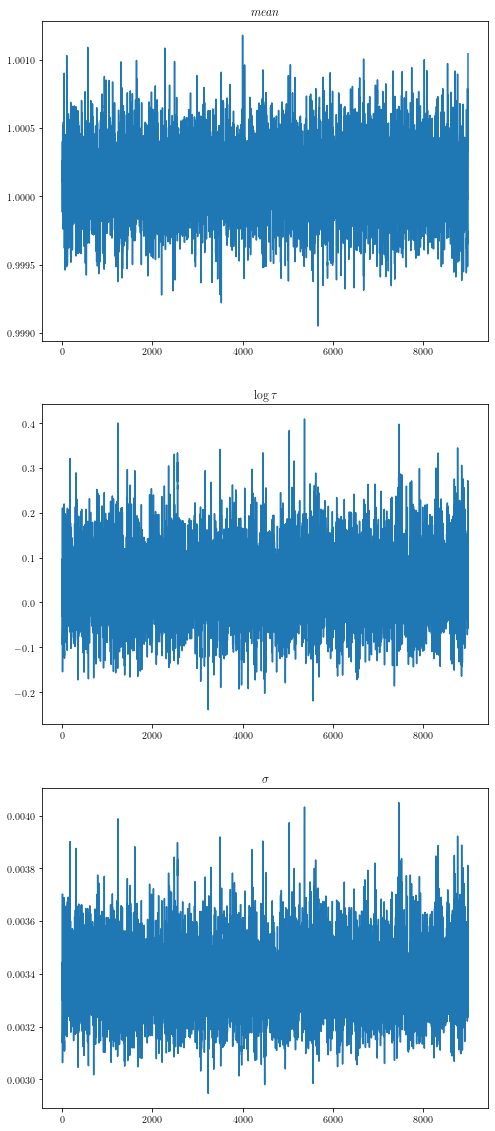

In [27]:
samples_drw = pm.trace_to_dataframe(
    trace_drw, varnames=["mean",r"$\log\tau$","$\sigma$"]
)
fig, ax = plt.subplots(len(samples_drw.columns),figsize=(8,20))
for a, col in zip(ax,samples_drw.columns):
    a.plot(samples_drw[col],label=col)
    a.set_title(r'${}$'.format(col))

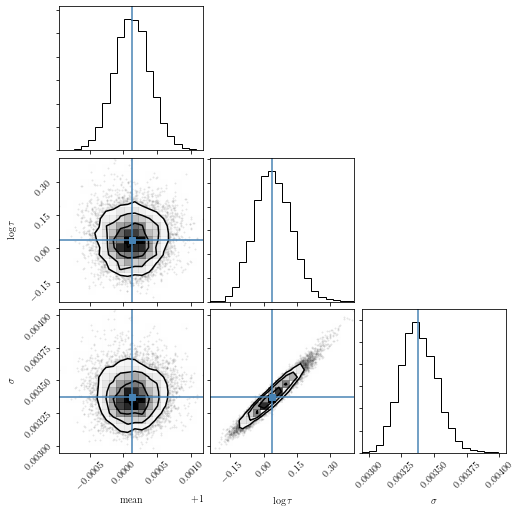

In [28]:
_ = corner.corner(samples_drw, truths = samples_drw.median())

In [29]:
# Generate 32 realizations of the prediction sampling randomly from the chain
N_pred = 32
pred_t = np.linspace(1350,1450,1000)
pred_mu = np.empty((N_pred, len(pred_t)))
pred_var = np.empty((N_pred, len(pred_t)))
pred_psd = np.empty((N_pred, len(freq)))

with model_drw:
    pred = gp.predict(pred_t, return_var=True, predict_mean=True)
    psd = kernel.psd(2*np.pi*freq)
    for i, sample in tqdm(enumerate(xo.get_samples_from_trace(trace_drw, size=N_pred)), total=N_pred):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)
        pred_psd[i] = xo.eval_in_model(psd, sample)

[Text(0, 0.5, 'PDCSAP Flux'), (1350, 1450), Text(0.5, 0, 'Time')]

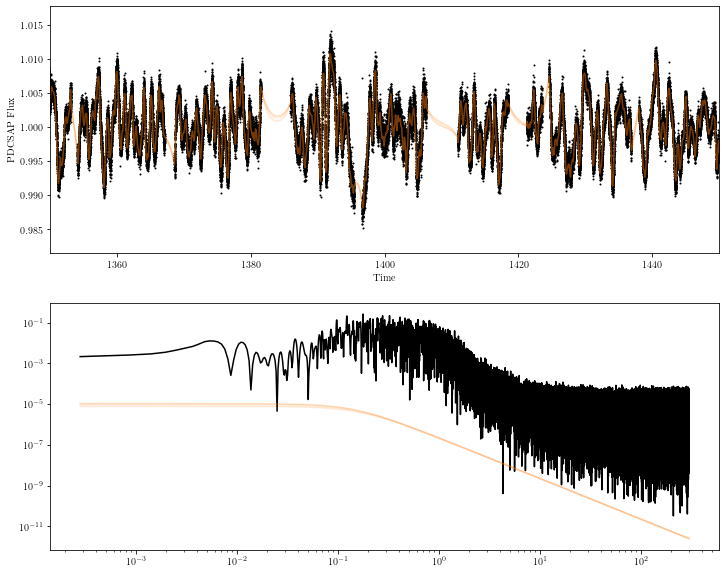

In [30]:
fig, ax = plt.subplots(2, figsize=(12,10))

ax[0].scatter(time, flux, s=1, c="k", label="data")
ax[1].loglog(freq, power, c='k', label='data')

# Plot the predictions
for i in range(len(pred_mu)//5):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    ps = pred_psd[i]
    label = None if i else "prediction"
    #art = ax[0].fill_between(pred_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    #art.set_edgecolor("none")
    ax[0].plot(pred_t, mu, color="C1", label=label, alpha=0.1)
    
    ax[1].loglog(freq, ps, color='C1', alpha=0.1)

ax[0].set(xlim=(1350,1450),xlabel='Time',ylabel='PDCSAP Flux')

# Rotation Term?

In [31]:
#Define the PyMC3 model...

with pm.Model() as model_rot:
    #posteriors into priors...
    mean = pm.Normal("mean", mu=1.0, sigma=np.std(flux))
    
    amp = pm.Normal("$A$", mu=np.std(flux), sigma=np.max(flux)-np.mean(flux))
    
    log_period = pm.Normal("$\log P$", mu=np.log(1/freq[np.argmax(power)]), sigma=2) 
    
    Q0 = pm.HalfFlat("$Q_0$")
    
    deltaQ = pm.Normal(r"$\Delta Q$", mu=0, sigma=1)
    
    mix = pm.Uniform("mix", 1e-10, 1-1e-10)
    
    kernel = terms.RotationTerm(amp=amp, log_period=log_period, Q0=Q0, deltaQ=deltaQ, mix=mix)

    gp = GP(kernel, time[::15], err[::15] ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=flux[::15])

In [32]:
with model_rot:
    map_soln = xo.optimize(start=model_rot.test_point)

optimizing logp for variables: [mix, $\Delta Q$, $Q_0$, $\log P$, $A$, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 75001.93897147507 -> 75001.93897147507


In [33]:
with model_rot:
    step = pm.NUTS(target_accept=0.95)
    trace_rot = pm.sample(
        tune=1000,
        draws=3000,
        cores=6,
        chains=3,
        step=step
    )

Multiprocess sampling (3 chains in 6 jobs)
NUTS: [mix, $\Delta Q$, $Q_0$, $\log P$, $A$, mean]
Sampling 3 chains: 100%|██████████| 12000/12000 [39:49<00:00,  5.02draws/s] 
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


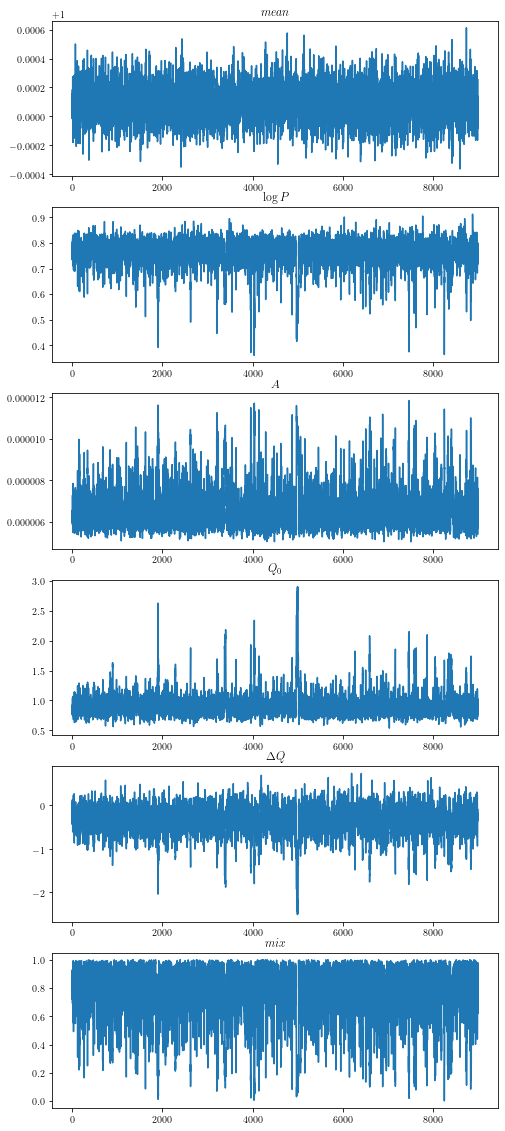

In [34]:
samples_rot = pm.trace_to_dataframe(
    trace_rot, varnames=["mean","$\log P$","$A$","$Q_0$","$\Delta Q$","mix"]
)
fig, ax = plt.subplots(len(samples_rot.columns),figsize=(8,20))
for a, col in zip(ax,samples_rot.columns):
    a.plot(samples_rot[col],label=col)
    a.set_title(r'${}$'.format(col))

In [35]:
pm.summary(trace_rot)

/Users/carina/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,1.000096,0.000127,2.116046e-06,0.999838,1.000338,3407.308020,1.000274
$A$,0.000007,0.000001,3.728777e-08,0.000005,0.000009,719.522927,1.002224
$\log P$,0.757768,0.055788,2.008834e-03,0.642426,0.850076,735.230607,1.001148
$\Delta Q$,-0.374512,0.350559,1.297749e-02,-1.037922,0.291691,673.814173,1.002780
$Q_0$,0.932107,0.221998,1.013617e-02,0.635656,1.312833,459.997169,1.003910
mix,0.764843,0.205970,7.329069e-03,0.323281,0.999985,744.634196,1.002009


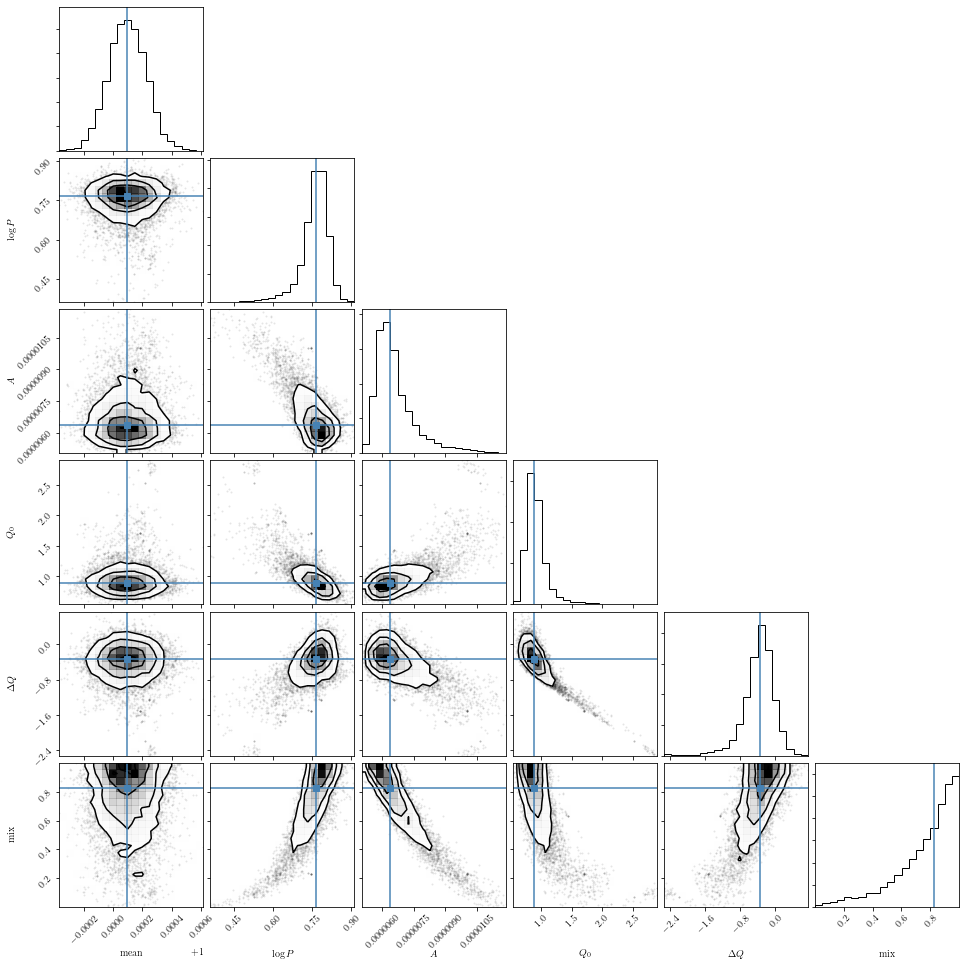

In [36]:
_ = corner.corner(samples_rot, truths = samples_rot.median())

In [37]:
# Generate 32 realizations of the prediction sampling randomly from the chain
N_pred = 32
pred_t = np.linspace(1350,1450,1000)
pred_mu = np.empty((N_pred, len(pred_t)))
pred_var = np.empty((N_pred, len(pred_t)))
pred_psd = np.empty((N_pred, len(freq)))

with model_rot:
    pred = gp.predict(pred_t, return_var=True, predict_mean=True)
    psd = kernel.psd(2*np.pi*freq)
    for i, sample in tqdm(enumerate(xo.get_samples_from_trace(trace_rot, size=N_pred)), total=N_pred):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)
        pred_psd[i] = xo.eval_in_model(psd, sample)

[Text(0, 0.5, 'PDCSAP Flux'), (1350, 1450), Text(0.5, 0, 'Time')]

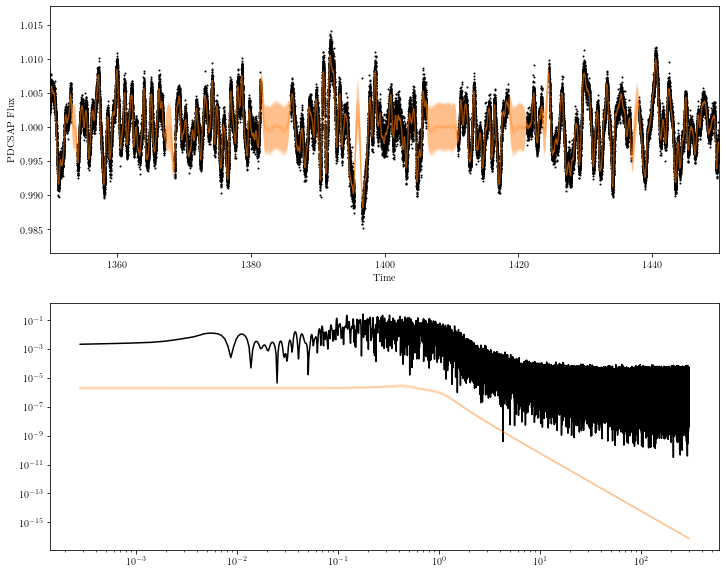

In [38]:
fig, ax = plt.subplots(2, figsize=(12,10))

ax[0].scatter(time, flux, s=1, c="k", label="data")
ax[1].loglog(freq, power, c='k', label='data')

# Plot the predictions
for i in range(len(pred_mu)//5):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    ps = pred_psd[i]
    label = None if i else "prediction"
    art = ax[0].fill_between(pred_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    ax[0].plot(pred_t, mu, color="C1", label=label, alpha=0.1)
    
    ax[1].loglog(freq, ps, color='C1', alpha=0.1)

ax[0].set(xlim=(1350,1450),xlabel='Time',ylabel='PDCSAP Flux')

In [41]:
np.unique(np.round(np.diff(time),decimals=3))

array([1.000e-03, 3.000e-03, 4.000e-03, 6.000e-03, 7.000e-03, 8.000e-03,
       1.000e-02, 1.100e-02, 1.200e-02, 1.300e-02, 1.400e-02, 1.500e-02,
       1.700e-02, 1.800e-02, 1.900e-02, 2.100e-02, 2.200e-02, 2.400e-02,
       2.500e-02, 2.800e-02, 3.100e-02, 4.200e-02, 4.400e-02, 4.600e-02,
       5.400e-02, 5.600e-02, 5.800e-02, 6.000e-02, 8.500e-02, 1.000e-01,
       5.250e-01, 9.330e-01, 9.360e-01, 1.029e+00, 1.043e+00, 1.046e+00,
       1.072e+00, 1.100e+00, 1.140e+00, 1.153e+00, 1.194e+00, 1.312e+00,
       1.372e+00, 1.450e+00, 1.587e+00, 1.672e+00, 2.086e+00, 2.250e+00,
       2.368e+00, 2.504e+00, 2.726e+00, 3.004e+00, 4.169e+00, 4.333e+00,
       4.435e+00, 4.689e+00, 5.939e+00])

In [26]:
center_time = time[(time>=time.min()-6) & (time<=time.max()+6)][::10]
vec = np.empty((len(center_time),6))

tau = 0.3

for i in range(6):
    dt = (center_time - i*tau).values
    f = np.interp(dt, time, flux)
    vec[:,i] = f

In [27]:
from tqdm.notebook import tqdm
eps = 0.3

RM = np.array([[np.linalg.norm(vec[i,:]-vec[j,:]) for j in range(vec.shape[0])] for i in tqdm(range(vec.shape[0]))])

In [34]:
RM_clip = np.heaviside(-(RM-0.004),1)

[(1325.296208223915, 1682.3446472549176), Text(0.5, 0, 'Time')]

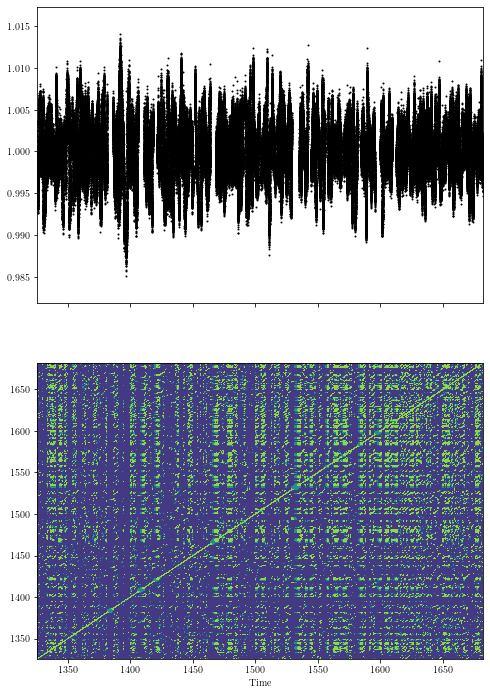

In [35]:
fig, ax = plt.subplots(2,1,figsize=(8,12),sharex=True)

ax[0].scatter(time, flux, s=1,c='k')
ax[1].contourf(center_time[::5],center_time[::5],RM_clip[::5,::5],levels=2)
ax[1].set(xlim=(center_time.min(),center_time.max()),xlabel='Time')

In [36]:
RR = []
for eps in tqdm(np.logspace(-3,-1,100)):
    clipped = np.heaviside(eps-RM,1)
    RR.append(clipped.sum()/(RM.shape[0]**2.0))

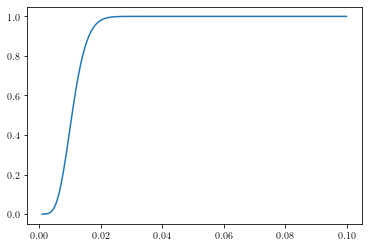

In [37]:
plt.plot(np.logspace(-3,-1,100),RR)